In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
from joblib import dump, load
from datetime import datetime
os.chdir("C:/Users/Titouan/Documents/HepavirAlgo")
pd.set_option("display.max_columns", None)
import funcsnds.featureselection as fs
import funcsnds.predstatus as ps
import funcsnds.globalvar as gv
import funcsnds.decisionrules as dr
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, plot_roc_curve, plot_precision_recall_curve

In [3]:
path_snds = "D:/Data/HEPAT_VUE_30012023/HEP_CSV/"
snds_hepather = pd.read_csv("data/chainage_snds_statut_hepather.csv").drop_duplicates()

In [4]:
how_many_vars = 10
cat_target = "HEPAD"

# Importation des résultats, du modèle et des tables sous-jacentes

In [5]:
curated_vars = None

In [6]:
if curated_vars == None :
    model_score = load("results/" + cat_target + "/model_cv.joblib")
    df_total_score = pd.read_csv("results/" + cat_target + "/df_score_year.csv", sep = ";")
else:
    model_score = load("results/" + cat_target + "/model_cv_curated.joblib")
    df_total_score = pd.read_csv("results/" + cat_target + "/df_score_year_curated.csv", sep = ";")

In [7]:
data_allnumenq = []
for myyear in range(12,22):
    if curated_vars == None :
        temp = pd.read_csv("results/" + cat_target + "/data/all_numenq_" + str(myyear) + ".csv", sep = ";")
    else:
        temp = pd.read_csv("results/" + cat_target + "/data_curated/all_numenq_" + str(myyear) + ".csv", sep = ";")
    data_allnumenq.append(temp)

In [8]:
metrics_curve = []
for threshold in range(1,100):
    df_total_score["decision_01"] = df_total_score.apply(lambda x : dr.rule_allspan(x, threshold/100), axis = 1)
    class_report = classification_report(df_total_score[cat_target], df_total_score["decision_01"], output_dict = True)
    row = [threshold/100, 
       np.round(100*class_report["1.0"]["precision"], 1), 
       np.round(100*class_report["1.0"]["recall"], 1),
       np.round(100*class_report["0.0"]["precision"], 1),
       np.round(100*class_report["0.0"]["recall"], 1)]
    metrics_curve.append(row)

In [9]:
metrics_curve_df = pd.DataFrame(metrics_curve, columns = ("Seuil", "Precision", "Sensibilite", "Prec_neg", "Specificite"))

In [10]:
metrics_curve_df.tail(20)

Seuil  Precision  Sensibilite  Prec_neg  Specificite
79   0.80       37.1         71.9      99.2         96.8
80   0.81       39.0         71.9      99.2         97.0
81   0.82       39.0         71.9      99.2         97.0
82   0.83       39.0         71.9      99.2         97.0
83   0.84       41.1         71.9      99.2         97.3
84   0.85       41.8         71.9      99.2         97.3
85   0.86       42.6         71.9      99.2         97.4
86   0.87       42.3         68.8      99.2         97.5
87   0.88       42.3         68.8      99.2         97.5
88   0.89       43.8         65.6      99.1         97.8
89   0.90       48.8         65.6      99.1         98.2
90   0.91       50.0         65.6      99.1         98.3
91   0.92       50.0         65.6      99.1         98.3
92   0.93       50.0         65.6      99.1         98.3
93   0.94       51.3         62.5      99.0         98.4
94   0.95       51.3         62.5      99.0         98.4
95   0.96       57.6         59.4      98.9         98.8
96   0.97       63.0         53.1      98.8         99.2
97   0.98       68.2         46.9      98.6         99.4
98   0.99       77.8         43.8      98.5         99.7

In [11]:
metrics_curve_df.to_csv("results/" + cat_target + "/metrics_curve.csv", sep = ";", index = False)

In [30]:
newthresh = 0.95
df_total_score["decision_01"] = df_total_score.apply(lambda x : dr.rule_allspan(x, newthresh), axis = 1)
#df_total_score["count_decision"] = df_total_score.apply(lambda x : dr.count_allspan(x, newthresh), axis = 1)

In [31]:
class_report = classification_report(df_total_score[cat_target], df_total_score["decision_01"], output_dict = True)

In [32]:
print(classification_report(df_total_score[cat_target], df_total_score["decision_01"]))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1202
         1.0       0.51      0.62      0.56        32

    accuracy                           0.97      1234
   macro avg       0.75      0.80      0.78      1234
weighted avg       0.98      0.97      0.98      1234



In [33]:
tn, fp, fn, tp = confusion_matrix(df_total_score[cat_target], df_total_score["decision_01"]).ravel()
conf_mat = confusion_matrix(df_total_score[cat_target], df_total_score["decision_01"])
print(conf_mat)

[[1183   19]
 [  12   20]]


In [34]:
print(f"La sensibilité (rappel, ou 'rappel des positifs') est de {np.round(tp/(tp+fn),2)}")

La sensibilité (rappel, ou 'rappel des positifs') est de 0.62


In [35]:
print(f"La spécificité (ou 'rappel des négatifs') est de {np.round(tn/(tn+fp),2)}")

La spécificité (ou 'rappel des négatifs') est de 0.98


# Error analysis : pourquoi s'est-on trompé ?

In [87]:
df_total_score[(df_total_score[cat_target] != df_total_score["decision_01"])].shape

(350, 12)

## 1) Expliquer les faux positifs : des codes CIM 10 présents

In [88]:
df_total_score[(df_total_score[cat_target] == 0) & (df_total_score["decision_01"] == 1)].shape

(196, 12)

In [89]:
list_fp = list(df_total_score[(df_total_score[cat_target] == 0) & (df_total_score["decision_01"] == 1)]["NUM_ENQ"])

In [91]:
count_B181 = 0
list_fp_womtf = []
list_fp_ald = []
for patient in list_fp:
    count_patient = 0
    for i in range(1,8):
        df_temp = data_allnumenq[i]
        single_obs = df_temp[df_temp["NUM_ENQ"] == patient]
        try:
            value_mtf = float(single_obs["MED_MTF_COD/B182"])
            if value_mtf > 0:
                count_patient = 1
                list_fp_ald.append(patient)
        except:
            pass
    
    if (count_patient == 0):
        list_fp_womtf.append(patient)
    
    count_B181 += count_patient

In [92]:
perc_B181 = np.round(100*count_B181/len(list_fp), 0)
print(f'Il y a {count_B181} patients avec une ALD B181 = Hépatite virale chronique B soit {perc_B181} % des faux-positifs. On explique donc très facilement un tiers du manque de précision')

Il y a 143 patients avec une ALD B181 = Hépatite virale chronique B soit 73.0 % des faux-positifs. On explique donc très facilement un tiers du manque de précision


In [93]:
ir_imb_r = pd.read_csv(path_snds + "IR_IMB_R_202212.csv", 
                   usecols = ["NUM_ENQ", "MED_MTF_COD", "IMB_ALD_DTD", "IMB_ALD_DTF", "INS_DTE", "UPD_DTE"],
                   sep = ";")

In [94]:
check_ald = ir_imb_r[ir_imb_r["NUM_ENQ"].isin(list_fp_ald)].dropna()

In [95]:
check_ald["UPD_year"] = check_ald["UPD_DTE"].apply(lambda x: datetime.strptime(x, "%d/%m/%Y").year)
check_ald["DTD_year"] = check_ald["IMB_ALD_DTD"].apply(lambda x: datetime.strptime(x, "%d/%m/%Y").year)
check_ald["DTF_year"] = check_ald["IMB_ALD_DTF"].apply(lambda x: datetime.strptime(x, "%d/%m/%Y").year)
check_ald = check_ald[check_ald["MED_MTF_COD"] == "B181"].sort_values(["NUM_ENQ", "UPD_year"]).drop_duplicates("NUM_ENQ", keep = "last")

In [96]:
df_year = df_total_score[df_total_score["NUM_ENQ"].isin(list_fp_ald)][["NUM_ENQ", "year_incl"]]

In [97]:
def is_in_ald(year_incl, dtd, dtf):
    return ((year_incl >= dtd) & (year_incl <= dtf))

In [98]:
merged = pd.merge(left = check_ald, right = df_year)
merged["included"] = merged.apply(lambda x: is_in_ald(x["year_incl"], x["DTD_year"], x["DTF_year"]), axis = 1)

In [99]:
merged

MED_MTF_COD NUM_ENQ IMB_ALD_DTD IMB_ALD_DTF     INS_DTE     UPD_DTE  \
0        B181  FOICVT  05/02/2004  05/02/2009  03/08/2005  04/02/2012   

   UPD_year  DTD_year  DTF_year  year_incl  included  
0      2012      2004      2009     2013.0     False

In [100]:
count_ASS_B181 = 0
list_fp_woass = []
for patient in list_fp_womtf:
    count_patient = 0
    for i in range(8):
        df_temp = data_allnumenq[i]
        single_obs = df_temp[df_temp["NUM_ENQ"] == patient]
        try:
            value_mtf = int(single_obs["MCO/D/ASS_DGN/B182"])
            if value_mtf > 0:
                count_patient = 1
        except:
            pass
    
    if (count_patient == 0):
        list_fp_woass.append(patient)
    
    count_ASS_B181 += count_patient

In [101]:
count_ASS_B181

22

In [102]:
perc_B181 = np.round(100*count_ASS_B181/len(list_fp_womtf), 0)
print(f'Il y a {count_ASS_B181} patients avec une ALD B181 = Hépatite virale chronique B soit {perc_B181} % des faux-positifs. On explique donc  facilement encore un quart du manque de précision')

Il y a 22 patients avec une ALD B181 = Hépatite virale chronique B soit 42.0 % des faux-positifs. On explique donc  facilement encore un quart du manque de précision


In [104]:
#test = df_total_score[(df_total_score[cat_target] == 1) & (df_total_score["decision_01"] == 1) & (df_total_score["count_decision"] == 1)]

## 2) Pourquoi certains ne ressortent pas ? Des gens n'ayant aucun signe de parcours de soin...

Plus de détails dans le notebook "investigation" qui regarde des parcours individuels, voir si on rate des informations

In [105]:
df_total_score[(df_total_score[cat_target] == 1) & (df_total_score["decision_01"] == 0)].shape

(154, 12)

In [106]:
df_90 = df_total_score[(df_total_score[cat_target] == 1) & (df_total_score["decision_01"] == 0)]

In [107]:
max_elem = []
for elem in df_90["NUM_ENQ"]:
    test = np.max(np.array(df_90[df_90["NUM_ENQ"] == elem][df_90.columns[2:9]]))
    max_elem.append(test)

In [108]:
import matplotlib.pyplot as plt

In [109]:
np.quantile(max_elem, q = 0.5)

0.66

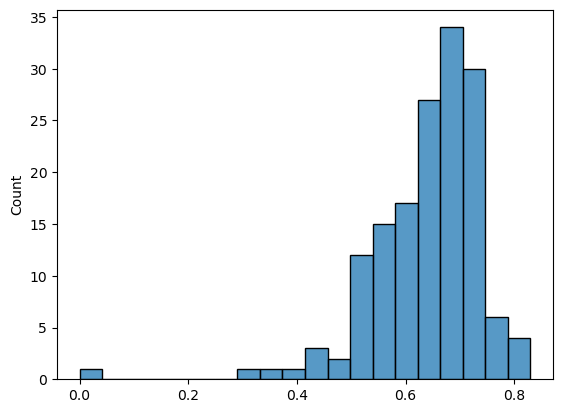

In [110]:
_ = sns.histplot(max_elem, bins = 20)

In [111]:
np.sum(pd.Series(max_elem) < 0.6)

38

In [113]:
len(max_elem)

154

In [114]:
np.sum(pd.Series(max_elem) > 0.95)

0

# Analyse individuelle

In [68]:
df_test = data_allnumenq[1]
single_obs = df_test[df_test["NUM_ENQ"] == who][list(model_score.feature_names_in_)]
model_score.predict_proba(single_obs)[0][1]

0.01126208

In [69]:
score_init = model_score.predict_proba(single_obs)[0][1]
myrow = []
for mycol in single_obs.columns:
    test = single_obs.copy()
    test[mycol] = 0
    mydiff = np.round(100*(model_score.predict_proba(test)[0][1] - score_init),2)
    myrow.append(mydiff)
    if mydiff < 0:
        print(mycol)
        print(mydiff)

BIO_PRS_IDE/519
-0.41


In [70]:
single_obs

BIO_PRS_IDE/1000  BIO_PRS_IDE/1104  BIO_PRS_IDE/1208  BIO_PRS_IDE/1740  \
15712               0.0               1.0               0.0               0.0   

       BIO_PRS_IDE/1806  BIO_PRS_IDE/2004  BIO_PRS_IDE/320  BIO_PRS_IDE/322  \
15712               0.0               0.0              0.0              1.0   

       BIO_PRS_IDE/323  BIO_PRS_IDE/351  BIO_PRS_IDE/353  BIO_PRS_IDE/354  \
15712              1.0              1.0              0.0              0.0   

       BIO_PRS_IDE/4120  BIO_PRS_IDE/4124  BIO_PRS_IDE/4125  BIO_PRS_IDE/4500  \
15712               1.0               0.0               0.0               0.0   

       BIO_PRS_IDE/4711  BIO_PRS_IDE/519  BIO_PRS_IDE/522  BIO_PRS_IDE/563  \
15712               0.0              2.0              2.0              0.0   

       CAM_PRS_IDE/BGQP002  CAM_PRS_IDE/BZQK001  CAM_PRS_IDE/DEQP003  \
15712                  0.0                  0.0                  0.0   

       CAM_PRS_IDE/DZQM006  CAM_PRS_IDE/EPPP003  CAM_PRS_IDE/HBGD036  \
15712                  0.0                  0.0                  0.0   

       CAM_PRS_IDE/HBLD036  CAM_PRS_IDE/HBQK389  CAM_PRS_IDE/HLQM002  \
15712                  0.0                  0.0                  0.0   

       CAM_PRS_IDE/JVJF004  CAM_PRS_IDE/JVJF008  CAM_PRS_IDE/QEQK004  \
15712                  0.0                  0.0                  0.0   

       CAM_PRS_IDE/QZRB001  CAM_PRS_IDE/YYYY015  CAM_PRS_IDE/YYYY166  \
15712                  0.0                  0.0                  0.0   

       CAM_PRS_IDE/YYYY600  CAM_PRS_IDE/ZCQJ004  CAM_PRS_IDE/ZCQM005  \
15712                  0.0                  0.0                  0.0   

       CAM_PRS_IDE/ZCQM008  CAM_PRS_IDE/ZZQH033  PHA_PRS_C13/C03CA  \
15712                  0.0                  0.0                0.0   

       PHA_PRS_C13/C07AA  PHA_PRS_C13/C10AA  PHA_PRS_C13/G03CA  \
15712                0.0                0.0                0.0   

       PHA_PRS_C13/H03AA  PHA_PRS_C13/J05AB  PHA_PRS_C13/J05AF  \
15712                0.0                0.0                0.0   

       PHA_PRS_C13/J05AR  PHA_PRS_C13/J07BB  PHA_PRS_C13/M01AE  \
15712                0.0                0.0                0.0   

       PHA_PRS_C13/M02AA  PHA_PRS_C13/N02AA  PHA_PRS_C13/N05BA  \
15712                0.0                0.0                0.0   

       PHA_PRS_C13/N05CF  PHA_PRS_C13/N06AB  PHA_PRS_C13/N06AX  \
15712                0.0                0.0                0.0   

       PHA_PRS_C13/N07BC  PHA_PRS_C13/R01AD  PHA_PRS_C13/V08AB  \
15712                0.0                0.0                0.0   

       PHA_PRS_C13/V08CA  PRS_NAT_REF/3315  PRS_NAT_REF/3316  PSP_SPE_COD/8  \
15712                0.0               0.0               0.0            0.0   

       UCD_UCD_COD/0000009233208  UCD_UCD_COD/0000009236247  \
15712                        0.0                        0.0   

       UCD_UCD_COD/0000009246642  UCD_UCD_COD/0000009274182  \
15712                        0.0                        0.0   

       UCD_UCD_COD/0000009288310  UCD_UCD_COD/0000009367587  \
15712                        0.0                        0.0   

       UCD_UCD_COD/0000009373381  UCD_UCD_COD/0000009373671  \
15712                        0.0                        0.0   

       UCD_UCD_COD/0000009397217  UCD_UCD_COD/0000009398211  \
15712                        0.0                        0.0   

       UCD_UCD_COD/0000009401108  UCD_UCD_COD/0000009402852  \
15712                        0.0                        0.0   

       UCD_UCD_COD/0000009405081  UCD_UCD_COD/0000009405744  \
15712                        0.0                        0.0   

       UCD_UCD_COD/0000009405750  UCD_UCD_COD/0000009415406  \
15712                        0.0                        0.0   

       UCD_UCD_COD/0000009418008  UCD_UCD_COD/0000009419806  \
15712                        0.0                        0.0   

       UCD_UCD_COD/0000009426195  UCD_UCD_COD/0000009428739  GRG_GHM/06K02  \
15712                

In [ ]:
test = single_obs.copy()
for mycol in single_obs.columns:
    test[mycol] = 0

In [ ]:
model_score.predict_proba(single_obs)[0][1]